# Data preparation  
1. Raw data came with different formats: HTML, dictionary...
2. This note deals with two tables:  
   (1) "job_listings_df": a table of real world job listings   
   where HTML tags and characters that are not letters are removed      
   (2) "ONET_df": O*NET database that contains labeled data  
   The output is a table containing occupation name, description, career cluster, and scores for each skills
   

## 0. Load in Library

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import time
import pandas as pd
import sys
import os
import json
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import io

In [2]:
filepath = '/Users/Wei.Zhao/Documents/2017_INSIGHT/github'

## 1. read in job listings table and clean up text

* The input job_listing table only contains three columns: job title, job description, company

In [3]:
job_listings_df=pd.read_csv(os.path.join(filepath,'job_listings.csv'))
print job_listings_df.columns

Index([u'title', u'company', u'description'], dtype='object')


* Job description is the most messy text that many entries contain html tags. So I need to:  
   (1) remove html tags  
   (2) remove any characters that are not letters  
   (3) turn words to lower case

In [4]:
def removeTag(onestring):
    s = re.sub('<.*?>', '', onestring)
    s = re.sub('[^a-zA-Z ]',' ',s)
    return s.lower()

* Job title, though sometimes does not communicate very well on what the opening position is about, however, rougly 30% of the times, it indeed say a lot of information about the job.   
* Here, I add job title to job description using pandas string concat function, and store in the 'text' column.

In [5]:
job_listings_df['text'] = job_listings_df['description'].str.cat(job_listings_df['title']) 
job_listings_df['text'] = job_listings_df['text'].apply(removeTag)

# remove any job description shorter than 30 words or longer than 3200 words
job_listings_df['len'] = job_listings_df['description'].apply(lambda x: len(x.split(' ')))
job_listings_df = job_listings_df[(job_listings_df['len']<3200)&(job_listings_df['len']>30)] 

# assign an id to job listings 
job_listings_df['original_id'] = job_listings_df.index

# drop 'description' columns since we already have 'text'('title'+'description)
job_listings_df.drop('description',axis=1, inplace=True)

# rename 'title' to 'listing_title', so we don't get confused
job_listings_df = job_listings_df.rename(columns={'title':'listing_title'})

print job_listings_df.columns

Index([u'listing_title', u'company', u'text', u'len', u'original_id'], dtype='object')


* save the cleaned job listings table

In [ ]:
job_listings_df.to_csv('listing_database_clean.csv',index = None)

## 2. read in O*Net Web data

* O*Net is my reference database  
* Detailed work activities, tasks are scraped from O*NET website https://www.onetonline.org
* The code below readin the O*NET web scaped table and clean the table. 

In [6]:
onet_df= pd.read_csv(os.path.join(filepath,'onet_db/jobdescription_final.csv'), index_col=0)

In [7]:
# Both 'Tasks' and "DetailedWorkActivities" are stored in dictionary
onet_df.head(2)

,Abilities,DetailedWorkActivities,Education,Interests,Job Zone,Knowledge,Occupation listing,Skills,Tasks,Technology,Tools,Wages & Employment Trends,Work Values,WorkActivities,WorkContext,WorkStyles,description,id,name,titles
0,{'Fluency of Ideas': 'The ability to come up w...,"{'Negotiate contracts for transportation, dist...","{'26': 'Masters degree', '22': 'Bachelors degr...",{'Enterprising': 'Enterprising occupations fre...,{'Education': 'Most of these occupations requi...,{'Psychology': 'Knowledge of human behavior an...,"{'11-3061.00': 'Purchasing Managers', '11-2022...",{'Active Listening': 'Giving full attention to...,{'Review reports submitted by staff members to...,{'Data base user interface and query software'...,"{'Mobile phones': 'Smartphones', 'Personal com...","{'Top industries (2014)': 'Self-Employed', 'St...",{'Recognition': 'Occupations that satisfy this...,"{'Organizing, Planning, and Prioritizing Work'...",{'Importance of Being Exact or Accurate': '40%...,{'Self Control': 'Job requires maintaining com...,Determine and formulate policies and provide o...,11-1011.00,Chief Executives,"['Chief Nursing Officer', 'Executive Director'..."
1,{'Inductive Reasoning': 'The ability to combin...,{'Maintain operational records for green energ...,"{'19': 'Post-baccalaureate certificate', '42':...",{'Enterprising': 'Enterprising occupations fre...,{'Education': 'Most of these occupations requi...,{'Engineering and Technology': 'Knowledge of t...,NaN,{'Judgment and Decision Making': 'Considering ...,{'Evaluate and approve proposals for sustainab...,{'Data base user interface and query software'...,"{'Mobile phones': 'Smartphones', 'Photocopiers...","{'Top industries (2014)': 'Self-Employed', 'St...",{'Working Conditions': 'Occupations that satis...,"{'Organizing, Planning, and Prioritizing Work'...",{'Importance of Being Exact or Accurate': '42%...,{'Self Control': 'Job requires maintaining com...,"Communicate and coordinate with management, sh...",11-1011.03,Chief Sustainability Officers,"['Supply Chain Manager', 'Vice President']"


* O*NET provides comprehensive information on occupations. Most relevant 'text' information to this project are :  
  (1) name (occupation title)  
  (2) titles (a list of similar titles to Occupation title)    
  (3) description (a high level summary about this occupation)    
  (4) tasks (the responsibilities)
  (5) DetailedWorkActivities (explain what this job does in more details) 

In [8]:
onet_df = onet_df.loc[:,['id','name','description','Tasks','DetailedWorkActivities','titles']].copy()
onet_df = onet_df.rename(columns={'id':'O*NET-SOC Code'})

In [9]:
for col in ['Tasks','DetailedWorkActivities','description','titles']:
    onet_df[col] = onet_df[col].apply(lambda x: re.sub('[^a-zA-Z ]',' ',x) if x not in [np.nan] else ' ')

# add titles, tasks, description to summary
onet_df['titles'] = onet_df['titles'].str.cat(onet_df['name'],sep=',')
onet_df['summary'] = onet_df['titles'].str.cat(onet_df['Tasks']).str.cat(onet_df['description'])
onet_df['summary']=onet_df['summary'].apply(lambda s: re.sub('[^a-zA-Z ]',' ',s).lower())

# assign id number to each entry
onet_df['id'] = onet_df.index

In [10]:
onet_df.drop([ u'name',u'titles', u'description', u'Tasks',u'DetailedWorkActivities'],axis=1, inplace=True)

In [11]:
onet_df.head(2)

,O*NET-SOC Code,summary,id
0,11-1011.00,chief nursing officer executive director ...,0
1,11-1011.03,supply chain manager vice president chi...,1


## 3. read in O*Net data in csv

* All_Career_Clusters contain the career cluster(pretty much like industry) for every occupation
* Join All_Career_clusters to the ONET table

In [12]:
career_clusters = pd.read_csv(os.path.join(filepath,'onet_db/All_Career_Clusters.csv'),sep=',')
career_clusters = career_clusters.rename(columns={'Code':'O*NET-SOC Code'})
onet_df = onet_df.merge(career_clusters, how='left',on = 'O*NET-SOC Code')

* O*NET also provides a set of well defined Skills and Knowledge necessary for each occupation
* And what is really nice is for each skill and knowledge, it has numerical ratings. These scores came  
  from survey.We will use median value. 

In [13]:
def read_file(filename,sep='\t'):
    return pd.read_csv(os.path.join(filepath,filename),sep=sep)

# Get the Importance (IM) Score
def read_in_onet_score(filename):
    '''Input: ####.txt, output two dataframe'''
    temp = read_file(filename)
    temp_IM = temp[temp['Scale ID']=='IM']
    temp_value = temp_IM[['O*NET-SOC Code','Element Name','Data Value']] # Data Value is median 
    temp_value = temp_value.pivot(index='O*NET-SOC Code',columns='Element Name',values='Data Value').reset_index()
    if filename.split('.')[0] =='Knowledge':
        temp_value = temp_value.rename(columns={'Mathematics':'Mathematics_Knowledge'})
    return temp_IM, temp_value   

#  table_1: slicing of original table only with IM scores, 
#  table_2: for each job code, the score for each items under Skills
Skills_IM,Skills_value = read_in_onet_score('onet_db/Skills.txt')  
Knowledge_IM, Knowledge_value = read_in_onet_score('onet_db/Knowledge.txt')

/Users/Wei.Zhao/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Score Distribution of Skills

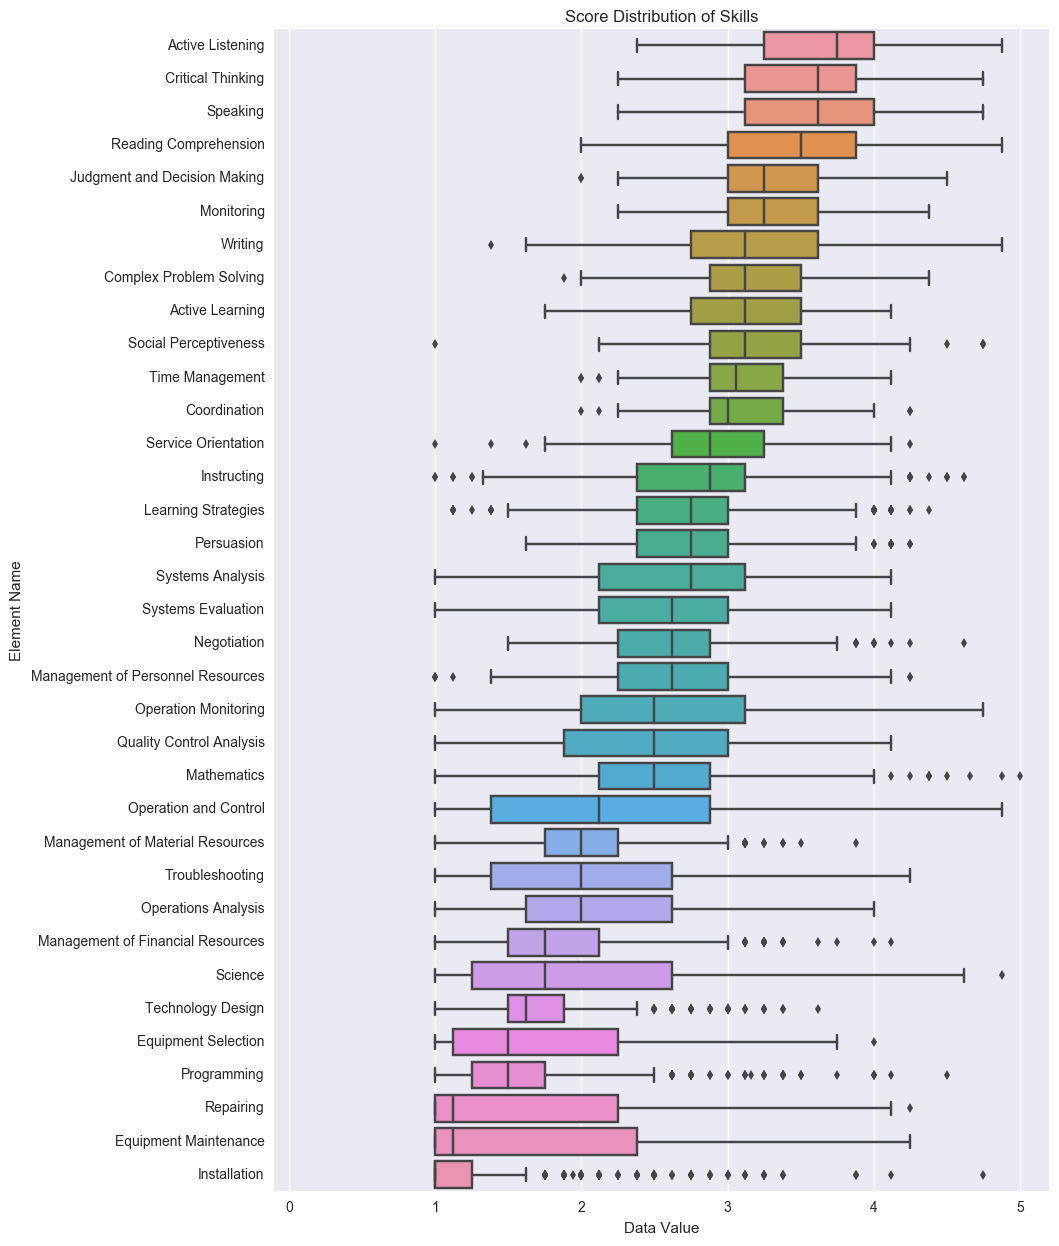

In [25]:
def plot_feature_score(score_df):
    Order = score_df.groupby('Element Name')['Data Value'].median().sort_values(ascending = False).index
    sns_plot = sns.boxplot(x='Data Value',y='Element Name',order=Order, data = score_df) 
    sns_plot.axes.set_xlim([-0.1,5.2])
plt.figure(figsize=(10,15))
plt.title('Score Distribution of Skills')
plot_feature_score(Skills_IM)

## Score Distribution of Knowledge

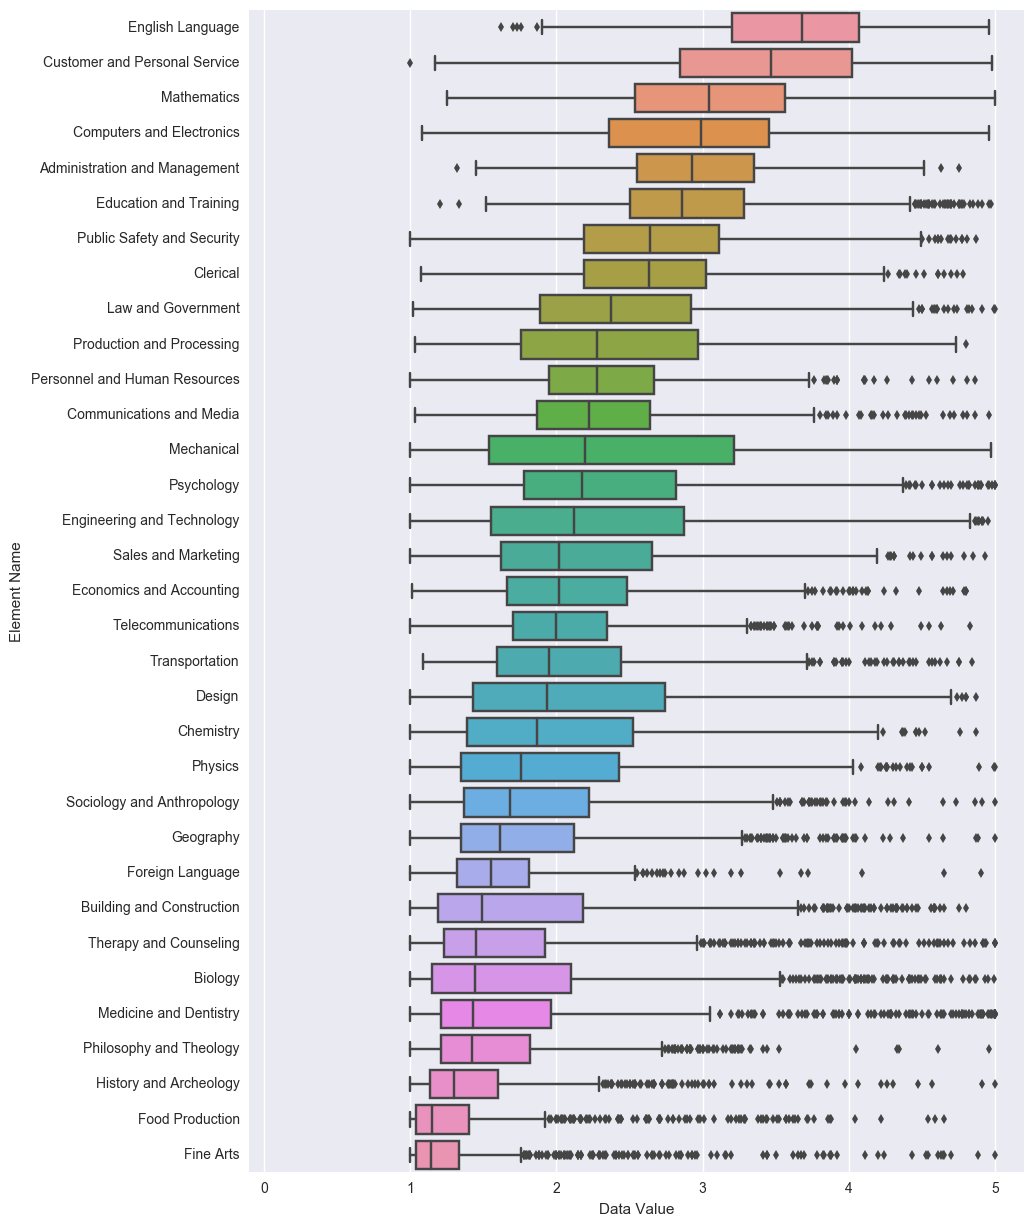

In [26]:
plt.figure(figsize=(10,15))
plot_feature_score(Knowledge_IM)

* Join Skills Scores and Knowledge Scores to ONET table

In [16]:
onet_all_df = onet_df.merge(Skills_value,how='left',on='O*NET-SOC Code').merge(Knowledge_value,how='left',on='O*NET-SOC Code')

In [17]:
onet_features_name = ['Skills','Knowledge']
onet_features_columns= [Skills_value.columns, Knowledge_value.columns]
def create_predictors(onet_features_name,onet_features_columns):
    predictors = {}
    for i, j in zip(onet_features_name, onet_features_columns):
        predictors[i]=list(j)
        predictors[i].remove('O*NET-SOC Code')
    all_predictors = reduce(lambda x,y:x+y, predictors.values())
    return all_predictors, predictors
all_predictors, predictors = create_predictors(onet_features_name,onet_features_columns)

* Write skills and knowledge name to Json file

In [18]:
def writeJson(data,filename):
    with io.open(filename,'w',encoding='utf-8') as f:
        s = json.dumps(data,indent=4,ensure_ascii=False)
        f.write(unicode(s))
writeJson(predictors,'predictors.json')

* Save ONET data

In [ ]:
onet_all_df.to_csv('onet_all_info.csv',index = None)

In [ ]:
# tried to remove verbs, but does not seem to help with the classification
'''
import nltk
sentence = """At eight o'clock on Thursday morning
... Arthur didn't feel very good."""
tokens = nltk.word_tokenize(sentence)


s = nltk.pos_tag(tokens)

ss= [x[0] for x in s if x[1] in set(['JJ','JJR','JJS','NN','NNS','NNP','NNPS'])]
def get_nouns(sentence):
    tokens = nltk.word_tokenize(sentence)
    s = nltk.pos_tag(tokens)
    nouns = [x[0].lower() for x in s if x[1] in set(['JJ','JJR','JJS','NN','NNS','NNP','NNPS'])]
    return ' '.join(nouns)
onet_df['key_summary'] = onet_df['summary'].apply(lambda astr: get_nouns(astr))
'''